In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


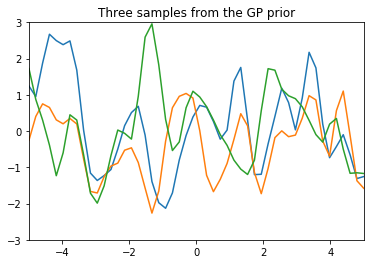

In [3]:


# Test data
n = 50
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# Define the kernel function
def kernel(a, b, param):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/param) * sqdist)

param = 0.1
K_ss = kernel(Xtest, Xtest, param)

# Get cholesky decomposition (square root) of the
# covariance matrix
L = np.linalg.cholesky(K_ss + 1e-15*np.eye(n))
# Sample 3 sets of standard normals for our test points,
# multiply them by the square root of the covariance matrix
f_prior = np.dot(L, np.random.normal(size=(n,3)))

# Now let's plot the 3 sampled functions.
plt.plot(Xtest, f_prior)
plt.axis([-5, 5, -3, 3])
plt.title('Three samples from the GP prior')
plt.show()

In [16]:
K_ss.shape

(50, 50)

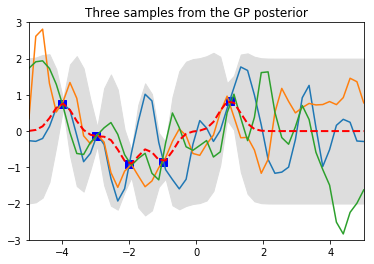

In [10]:
# Noiseless training data
Xtrain = np.array([-4, -3, -2, -1, 1]).reshape(5,1)
ytrain = np.sin(Xtrain)

# Apply the kernel function to our training points
K = kernel(Xtrain, Xtrain, param)
L = np.linalg.cholesky(K + 0.00005*np.eye(len(Xtrain)))

# Compute the mean at our test points.
K_s = kernel(Xtrain, Xtest, param)
Lk = np.linalg.solve(L, K_s)
mu = np.dot(Lk.T, np.linalg.solve(L, ytrain)).reshape((n,))

# Compute the standard deviation so we can plot it
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
stdv = np.sqrt(s2)
# Draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ss + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,3)))

pl.plot(Xtrain, ytrain, 'bs', ms=8)
pl.plot(Xtest, f_post)
pl.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="#dddddd")
pl.plot(Xtest, mu, 'r--', lw=2)
pl.axis([-5, 5, -3, 3])
pl.title('Three samples from the GP posterior')
pl.show()

In [13]:
# A one dimensional column vector of inputs.
Xtrain = np.array([-4, -3, -2, -1, 1]).reshape(5,1)
ytrain = np.sin(Xtrain)

with pm.Model() as model:
    # Specify the covariance function.
    cov_func = pm.gp.cov.ExpQuad(1, ls=0.1)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Latent(cov_func=cov_func)

    # Place a GP prior over the function f.
    f = gp.prior("f", X=X)

...

# After fitting or sampling, specify the distribution
# at new points with .conditional
Xnew = np.linspace(-1, 2, 50)[:, None]

with model:
    fcond = gp.conditional("fcond", Xnew=Xnew)

In [14]:
fcond.

Shape.0